<a href="https://colab.research.google.com/github/IamArmanNikkhah/TSP-GeneticAlgorithm/blob/main/GeneticAlghorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import random
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

In [ ]:
class fileReader:
  def __init__(self, filename):
    self.file_name = filename
    self.file_content = open(self.file_name, "r")

  def read_cityNum(self):
    cityNumTXT = self.file_content.readline()
    return int(cityNumTXT)
    
  
  def read_generationNum(self):
    generationNumTXT = self.file_content.readline()
    return int(generationNumTXT)


  def read_mutationProb(self):
    mutationProbTXT = self.file_content.readline()
    if float(mutationProbTXT) <= 1:
      return float(mutationProbTXT)
    else:
      print("Error!")
      return -404


  def read_crossoverProb(self):
    crossoverProbTXT = self.file_content.readline()
    if float(crossoverProbTXT) <= 1:
      return float(crossoverProbTXT)
    else:
      print("Error!")
      return -404


  def read_populationSize(self):
    populationSizeTXT = self.file_content.readline()
    return int(populationSizeTXT)
  
  def read_distanceMatrix(self):
    lines = []
    lines = self.file_content.readlines()
    distanceMatrix = [[int(num) for num in line.split()] for line in lines]
    return distanceMatrix
  
  def start(self):
    output_dict = {"cityNum":self.read_cityNum() , 
                   "generationNum":self.read_generationNum(),
                   "mutationProb" :self.read_mutationProb(),
                   "crossoverProb":self.read_crossoverProb(),
                   "populationSize":self.read_populationSize(),
                   "distanceMatrix":self.read_distanceMatrix()
                   }
    self.file_content.close()
    return output_dict

In [ ]:
class City:
  def __init__(self, indx_in_matrix):
    self.indx_in_matrix = indx_in_matrix
    self.cityID = "city_" + str(self.indx_in_matrix)
    self.visited = False
  
  def __repr__(self):
    return "( city name : " +  self.cityID + ", index : " + str(self.indx_in_matrix) +  " )"

In [ ]:
class Route:
    def __init__(self, cityOrder):
        self.cityOrder   = cityOrder
        self.routeLength = len(self.cityOrder)
        self.distance    = 0
        self.fitness     = 0.0
    
    def findcity(self, cityID):  #return index
      for indx in range(self.routeLength):
        if self.cityOrder[indx].cityID == cityID:
          return indx
    
    def __repr__(self):
      repr = ' '.join(self.cityOrder[i].cityID for i in range (self.routeLength))
      return "path: " + repr + " Cost: " + str(self.distance) + " Fitness: " + str(self.fitness)

In [ ]:
class TsmEnvironment:
  def __init__(self, cityNumber , distanceMatrix):
    self.cityNumber = cityNumber
    self.distanceMatrix = distanceMatrix
  
  def createEnv(self):
    self.cities = [City(indx) for indx in range(0, self.cityNumber)]

  def calculateDistance(self, cityA, cityB):
    indxA = cityA.indx_in_matrix
    indxB = cityB.indx_in_matrix
    return self.distanceMatrix[indxA][indxB]
  
  def routeCost(self, route):
    if route.distance == 0:
      pathDistance = 0
      for indx in range (route.routeLength):
        fromCity = route.cityOrder[indx]
        toCity = None
        if indx + 1 < route.routeLength:
          toCity = route.cityOrder[indx + 1]
        else:
          toCity = route.cityOrder[0]
          
        pathDistance += self.calculateDistance(fromCity, toCity)
    
      route.distance = pathDistance
        
    return route.distance

  def routeFitness(self, route):
    if route.fitness == 0:
        route.fitness = 1 / float(self.routeCost(route))
    return route.fitness
  

In [ ]:
class outputManager:
  def __init__(self, filename):
    self.file = open(filename, 'w')
    self.bestfitness_plot = []
    self.bestofbest_plot  = []
    self.averagefitness_plot = []
    
  
  def writePopulation(self, dict):
    pop  = dict["population"]
    for item in pop :
      self.file.write(item.__repr__())
      self.file.write("\n")
  
  def calculateAverage(self, dict):
    average = 0.0
    pop  = dict["population"]
    for item in pop :
      average += item.fitness
    average = average / len(pop)
    return average 
  
  def plot(self, dict):
    indx = [i for i in range(dict["generationNumber"] + 1)]
    plt.plot(indx, self.bestfitness_plot,'r' ,self.bestofbest_plot, 'b',self.averagefitness_plot, 'g')
    plt.show()

  def close(self):
    self.file.close()
  
  def record(self, dict):
    self.file.write(str(dict["generationNumber"])), self.file.write("  ")
    self.file.write(str(dict["bestFitnessThis"])),  self.file.write("  ")
    self.file.write(str(dict["bestOfbestGen"])),    self.file.write("  ")
    self.file.write(str(dict["bestOfbestFitness"])),self.file.write("\n")
    self.writePopulation(dict)
    self.bestfitness_plot.append(dict["bestFitnessThis"])
    self.bestofbest_plot.append(dict["bestOfbestFitness"])
    self.averagefitness_plot.append(self.calculateAverage(dict))
    self.plot(dict)



In [ ]:
class geneticAlghorithm:
  def __init__(self, env, chromosome_length, generation_number, mutation_prob, crossover_prob, population_size, output_manager):
    self.environment       = env
    self.chromosome_length = chromosome_length
    self.generation_number = generation_number
    self.mutation_prob     = mutation_prob
    self.crossover_prob    = crossover_prob
    self.population_size   = population_size
    self.output_manager    = output_manager

  def createRoute(self):
    cityOrder = random.sample(self.environment.cities, self.environment.cityNumber)
    return Route(cityOrder)
  
  def initializePopulation(self):
    population = []
    for i in range(0, self.population_size):
        population.append(self.createRoute())
    
    return population
  
  def rankRoutes(self):
    fitnessResults = []
    for i in range(0, self.population_size):
        fitnessResults.append(self.environment.routeFitness(self.population[i]))
    return sorted(self.population, key=lambda route: route.fitness, reverse=True)

  
  def selectParents_onlyTops(self):
    fitnessResults = self.rankRoutes()
    selectedPopulation = fitnessResults[0:self.population_size + 1]
    return selectedPopulation
  
  
  def selectParents_fitnessProportionate(self):
    selectedPopulation = []
    fitnessResults = self.rankRoutes()
    fitnessNumber_list = [fitnessResults[i].fitness for i in range(self.population_size)]
    df = pd.DataFrame(np.array(fitnessNumber_list), columns=['Fitness'])
    df['cumulative_sum'] = df.Fitness.cumsum()
    df['cumulative_perc'] = (100 * df.cumulative_sum) / df.Fitness.sum()
    for i in range (self.population_size):
        pick = 100 * random.random()
        for i in range(self.population_size):
            if pick <= df.iat[i,2]:
                selectedPopulation.append(fitnessResults[i])
                break
    return selectedPopulation

  def crossover_OX(self, parent1, parent2):
    
    crossover_prob = random.random()
    offspring1_cityOrder = []
    offspring2_cityOrder = []
    
    cutPoint1 = int(random.random() * parent1.routeLength)
    cutPoint2 = int(random.random() * parent2.routeLength)
    
    startPoint = min(cutPoint1, cutPoint2)
    endPoint   = max(cutPoint1, cutPoint2)

    for i in range(startPoint, endPoint):
        offspring1_cityOrder.append(parent1.cityOrder[i])
        
    offspring2_cityOrder = [item for item in parent2.cityOrder if item not in offspring1_cityOrder]

    if crossover_prob < self.crossover_prob:
      chidRoute  = Route(offspring1_cityOrder + offspring2_cityOrder)
    else:
      chidRoute  = parent1

    
    return chidRoute

  def crossover_custom(self, parent1, parent2):
    offspring_cityOrder = []
    if(random.random() < self.crossover_prob):
      startINDX = int(random.random() * parent1.routeLength)
      for i in range(0, startINDX):
        offspring_cityOrder.append(parent1.cityOrder[i])
      for i in range(startINDX, parent2.routeLength):
        if parent2.cityOrder[i] not in offspring_cityOrder:
          offspring_cityOrder.append(parent2.cityOrder[i])
      for j in range(0, parent2.routeLength):
        if parent2.cityOrder[j] not in offspring_cityOrder:
          offspring_cityOrder.append(parent2.cityOrder[j])

      return Route(offspring_cityOrder)
    
    return parent1
      

  def crossover_CX(self, parent1, parent2):
    offspring_cityOrder = []
    if(random.random() < self.crossover_prob):
      visited_indx        = []
      indx_1 = 0
      indx_2 = 0
      visited_indx.append(indx_2)
      offspring_cityOrder.append(parent2.cityOrder[indx_2])
      while indx_2 != parent2.findcity(parent1.cityOrder[0]):
        indx_1 = parent1.findcity(parent2.cityOrder[indx_2])
        indx_2 = indx_1
        indx_1 = parent1.findcity(parent2.cityOrder[indx_2])
        indx_2 = indx_1
        visited_indx.append(indx_2)
        indx_1 = parent1.findcity(parent2.cityOrder[indx_2])
        indx_2 = indx_1
        visited_indx.append(indx_2)
        offspring_cityOrder.append(parent2.cityOrder[indx_2])
      if len(offspring_cityOrder) != self.chromosome_length:
        unvisited_indx = [ i for i in range(self.chromosome_length) if i not in visited_indx]
        indx_2 = min(unvisited_indx)
        while len(visited_indx) != self.chromosome_length:
          indx_1 = parent1.findcity(parent2.cityOrder[indx_2])
          indx_2 = indx_1
          indx_1 = parent1.findcity(parent2.cityOrder[indx_2])
          indx_2 = indx_1
          visited_indx.append(indx_2)
          indx_1 = parent1.findcity(parent2.cityOrder[indx_2])
          indx_2 = indx_1
          visited_indx.append(indx_2)
          offspring_cityOrder.append(parent2.cityOrder[indx_2])
        
        if len(offspring_cityOrder) != self.chromosome_length:
          for item in parent1.cityOrder not in offspring_cityOrder:
            offspring_cityOrder.append(item)

      return Route(offspring_cityOrder)
    return parent1


  def crossoverPopulation(self, func):
    children = []
    pool = random.sample(self.population, self.population_size)
    for i in range(0, self.population_size):
        child = func(pool[i], pool[self.population_size - i - 1])
        children.append(child)
    return children


  def mutation_swap(self, route):
    for swap_in in range(route.routeLength):
        if(random.random() < self.mutation_prob):
            swap_out = int(random.random() * route.routeLength)
            city1 = route.cityOrder[swap_in]
            city2 = route.cityOrder[swap_out]
            route.cityOrder[swap_in]  =  city2
            route.cityOrder[swap_out] = city1
    return route

  def mutation_shuffle(self, route):
    if(random.random() < self.mutation_prob):
      startINDX = int(random.random() * route.routeLength)
      step      = int(random.random() * (route.routeLength - startINDX - 1)) + 1
      endINDX   = startINDX  +  step
      copy      = route.cityOrder[startINDX:endINDX+1]
      random.shuffle(copy)
      route.cityOrder[startINDX:endINDX+1] = copy
      
    return route

  def mutation_inverse(self, route):
    if(random.random() < self.mutation_prob):
      startINDX = int(random.random() * route.routeLength)
      step      = int(random.random() * (route.routeLength - startINDX - 1)) + 1
      endINDX   = startINDX  +  step
      copy      = route.cityOrder[startINDX:endINDX+1]
      copy.reverse()
      route.cityOrder[startINDX:endINDX+1]  = copy
    return route

  def mutatePopulation(self , func):
    mutatedPop = []
    for indx in range(self.population_size):
        mutatedPop.append(func(self.population[indx]))
    return mutatedPop

  def nextGeneration(self):
    selectionResults = self.selectParents_fitnessProportionate()
    self.population  = selectionResults
    self.population  = self.crossoverPopulation(self.crossover_OX)    #crossover
    nextGeneration =  self.mutatePopulation(self.mutation_swap)
    return nextGeneration

  def run(self):
    generation_num   = 0
    self.population  = self.initializePopulation()
    bestFitness_thisGeneration = self.rankRoutes()[0].fitness
    bestOfbest                 = (generation_num, bestFitness_thisGeneration)
    record                     = {"generationNumber":generation_num, "bestFitnessThis":bestFitness_thisGeneration, 
                                  "bestOfbestGen":bestOfbest[0], "bestOfbestFitness":bestOfbest[1], "population":self.population}
    self.output_manager.record(record)
    
    for i in range(0, self.generation_number):
      generation_num += 1
      self.population = self.nextGeneration()
      bestFitness_thisGeneration = self.rankRoutes()[0].fitness        
      if bestFitness_thisGeneration > bestOfbest[1]:
        bestOfbest               = (generation_num, bestFitness_thisGeneration)
      record                     = {"generationNumber":generation_num, "bestFitnessThis":bestFitness_thisGeneration, 
                                  "bestOfbestGen":bestOfbest[0], "bestOfbestFitness":bestOfbest[1], "population":self.population}
      self.output_manager.record(record)

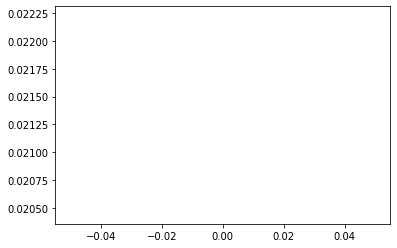

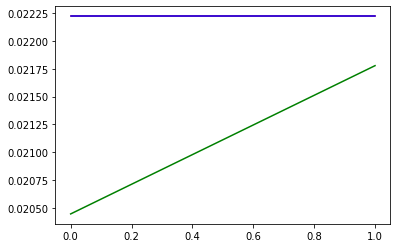

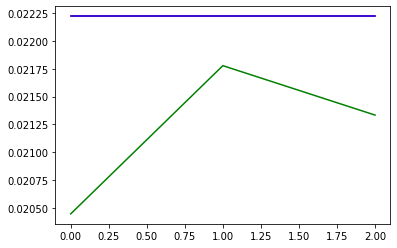

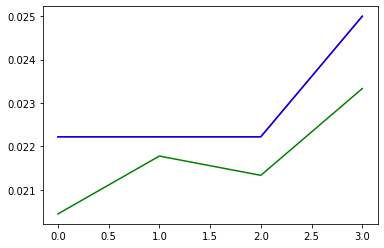

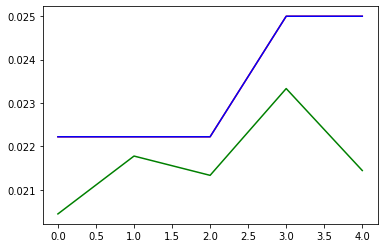

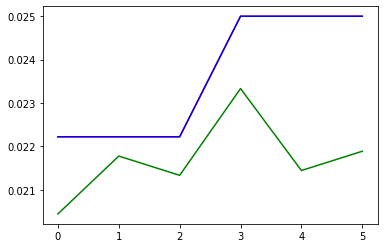

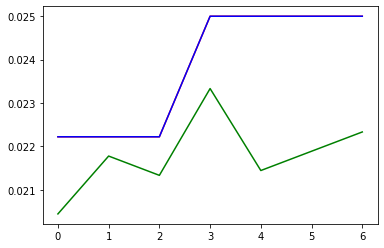

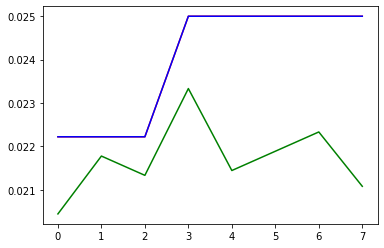

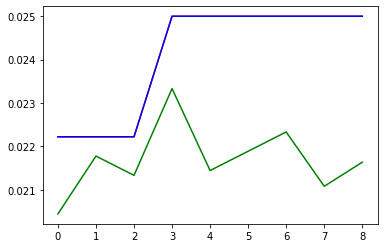

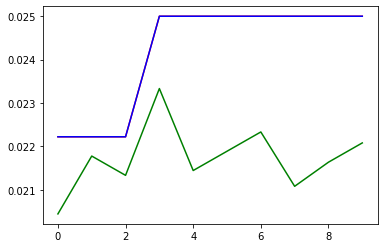

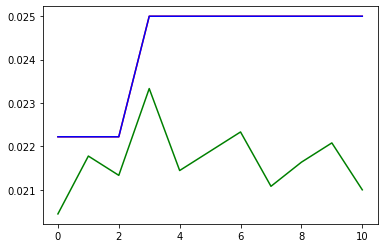

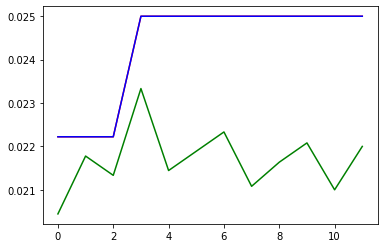

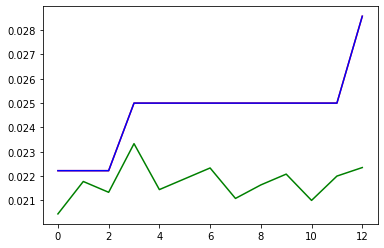

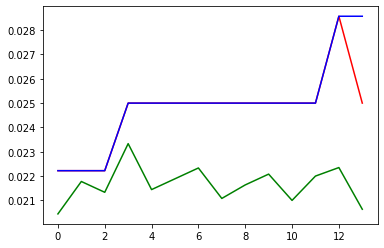

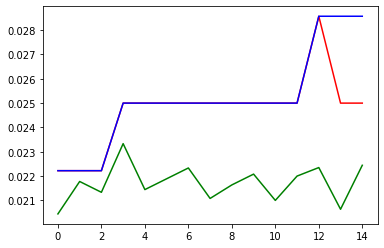

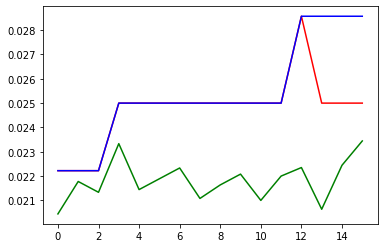

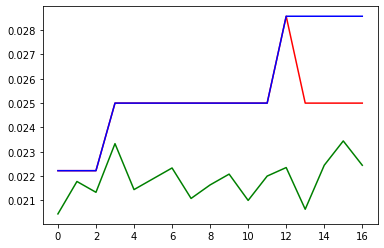

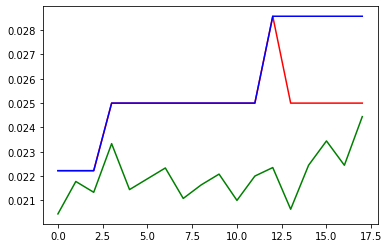

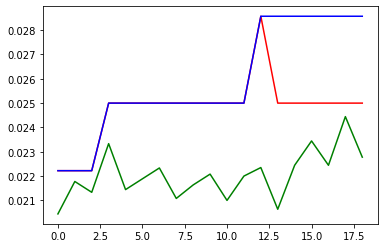

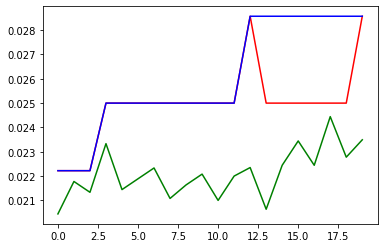

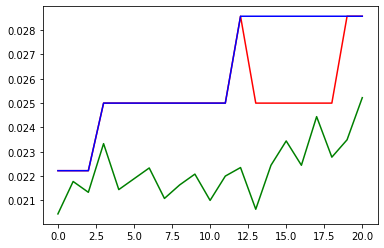

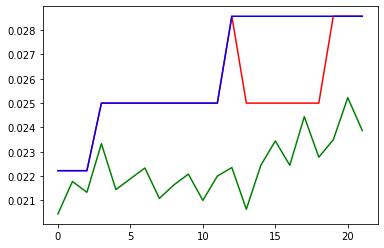

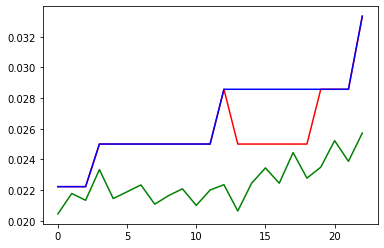

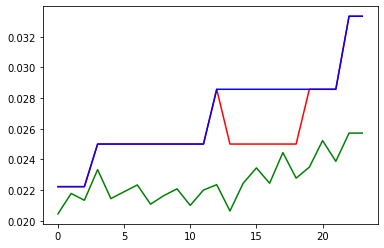

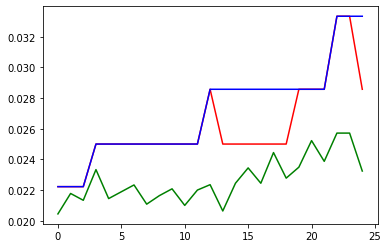

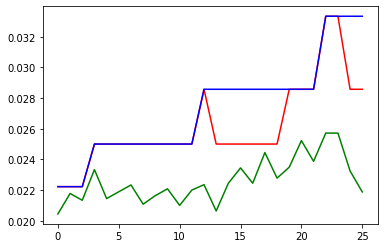

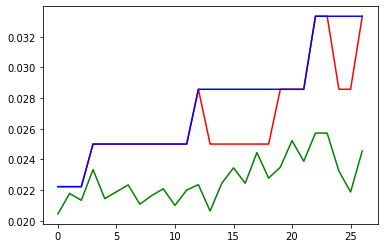

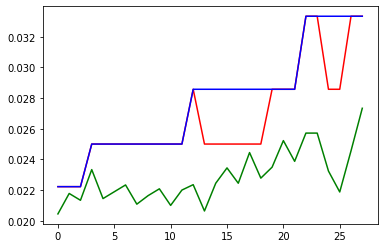

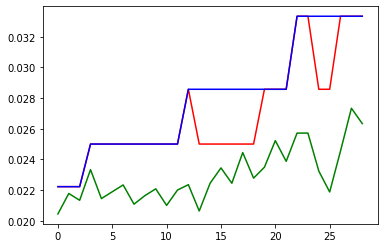

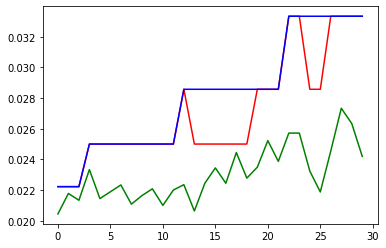

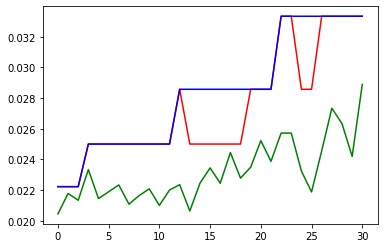

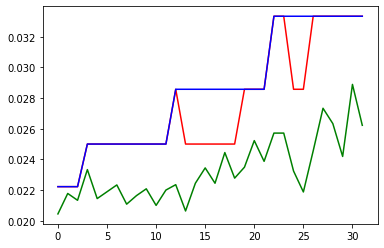

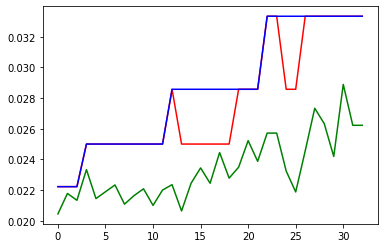

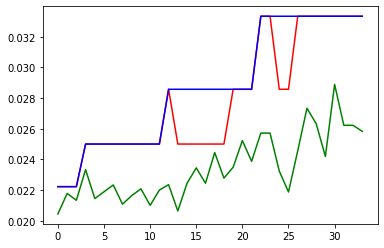

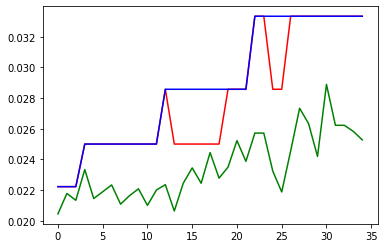

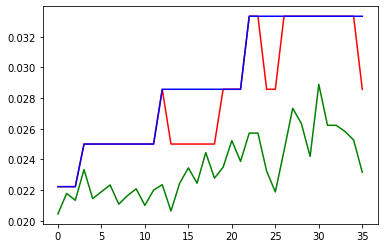

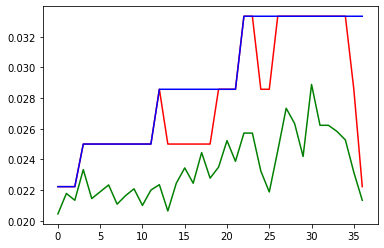

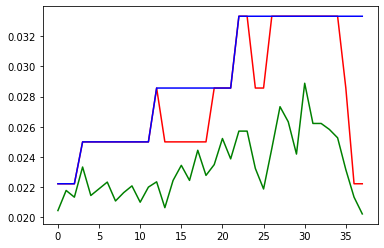

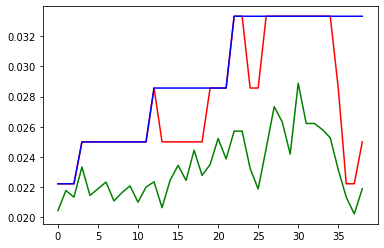

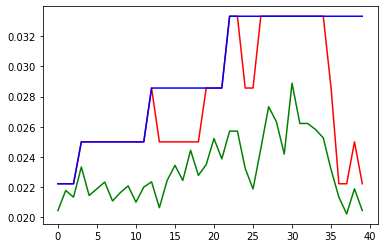

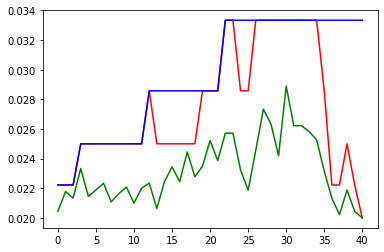

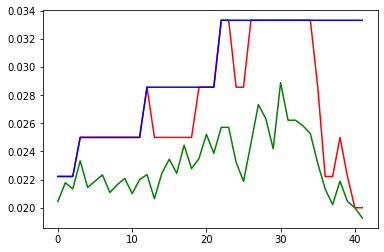

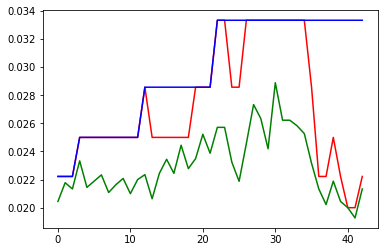

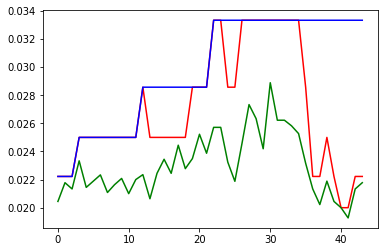

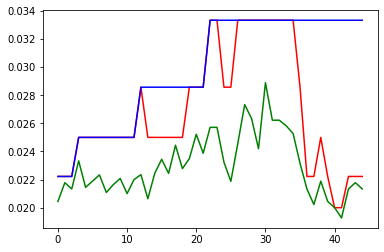

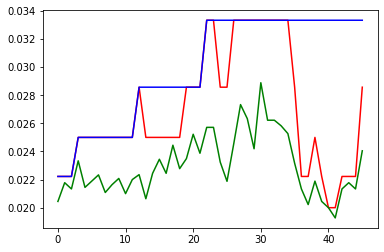

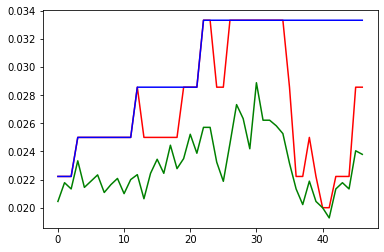

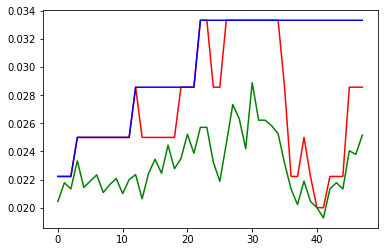

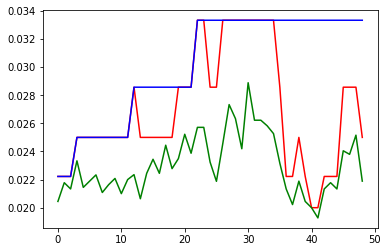

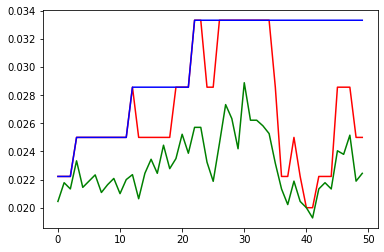

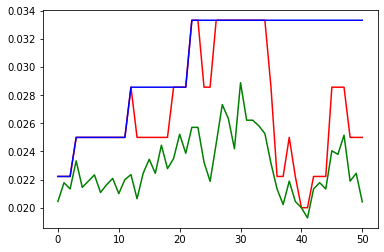

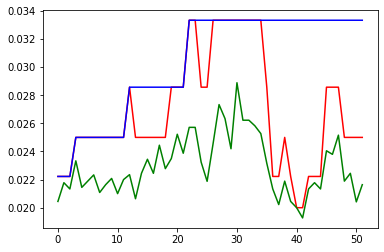

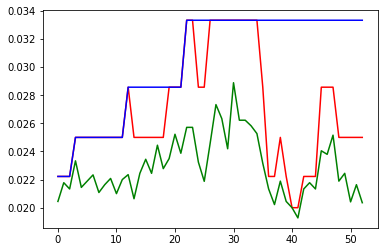

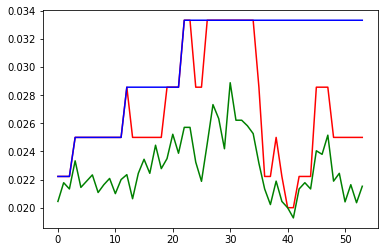

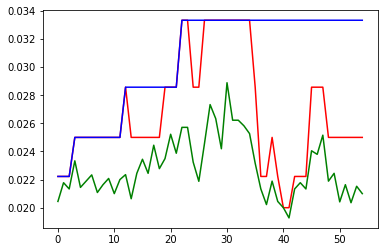

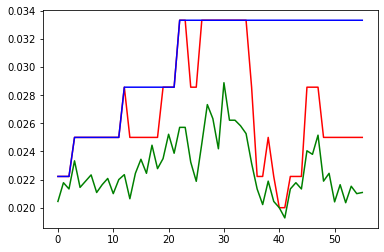

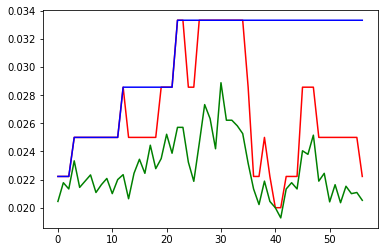

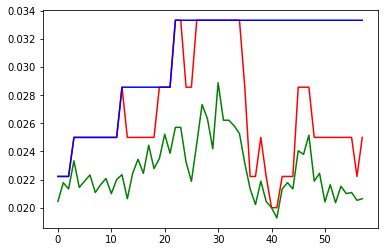

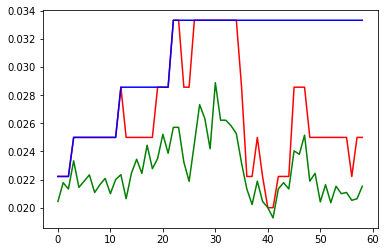

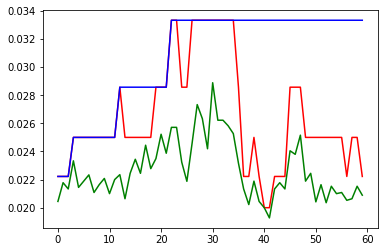

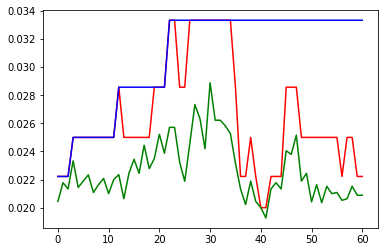

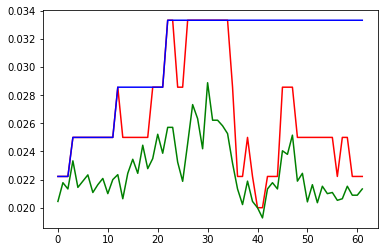

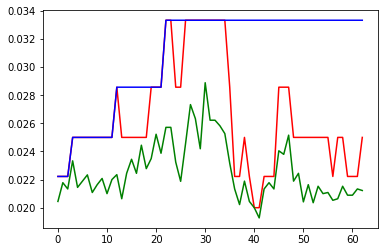

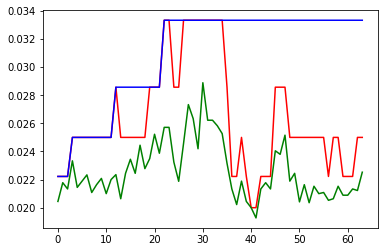

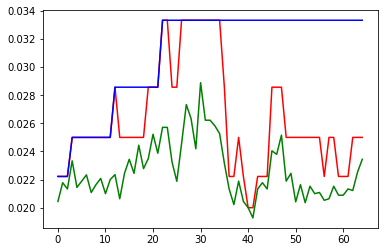

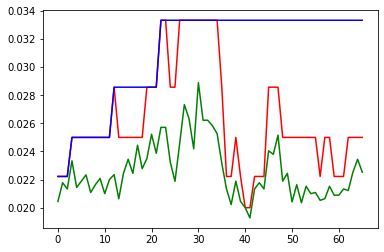

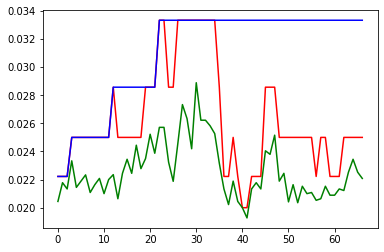

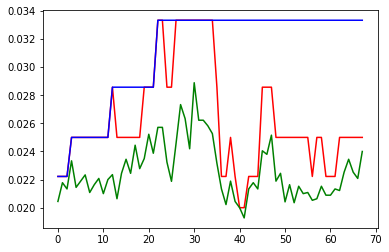

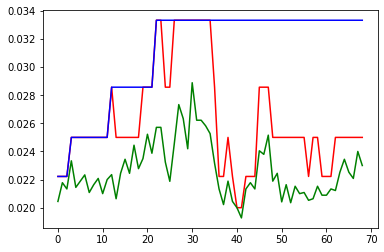

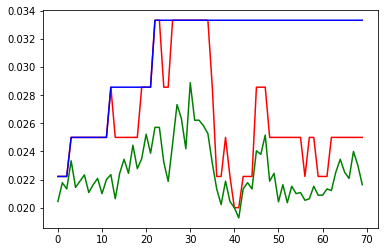

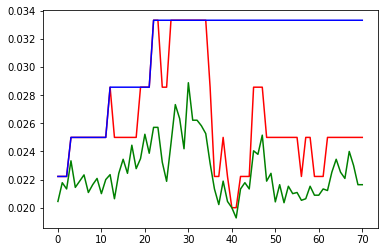

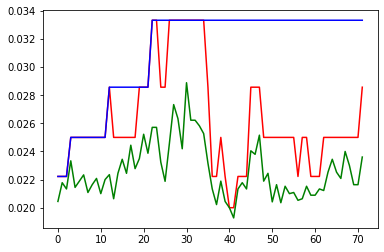

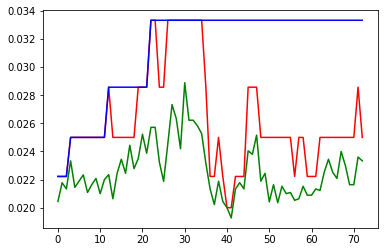

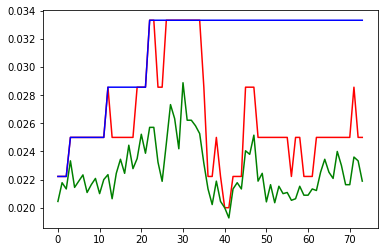

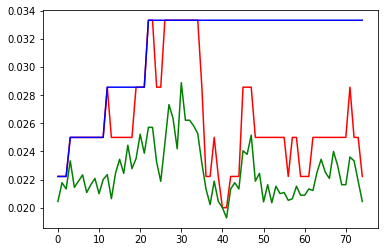

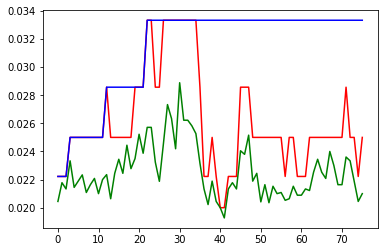

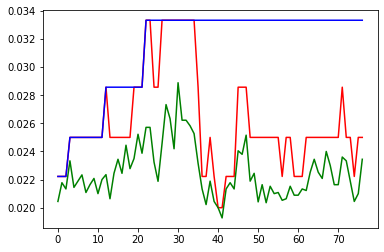

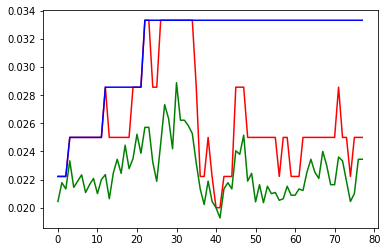

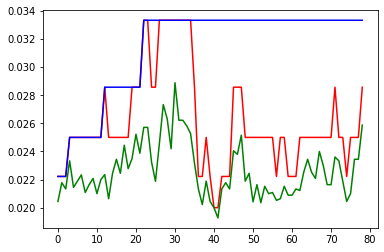

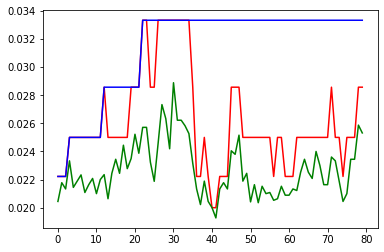

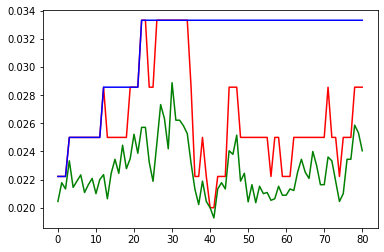

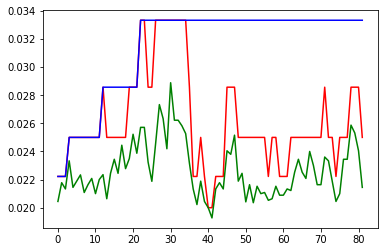

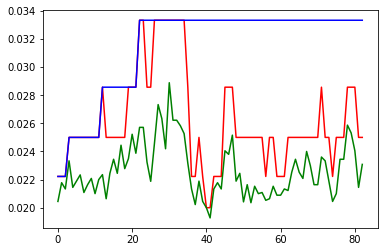

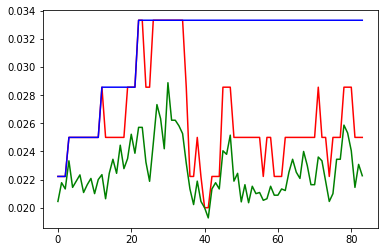

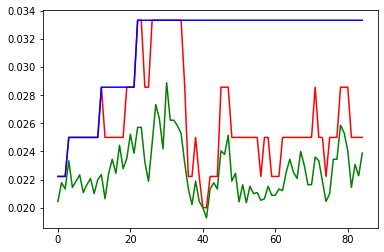

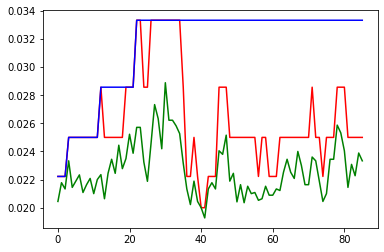

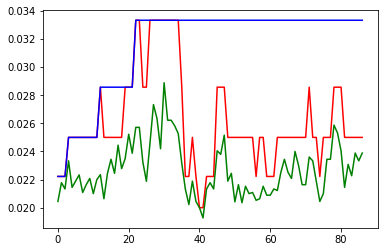

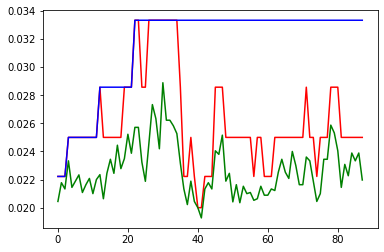

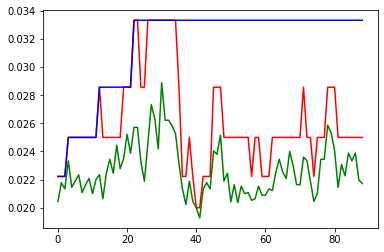

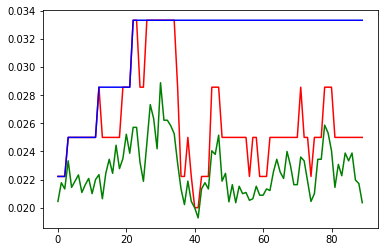

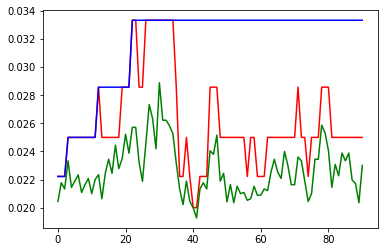

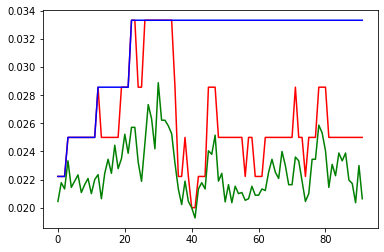

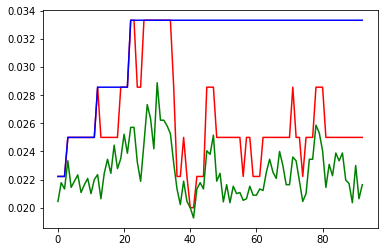

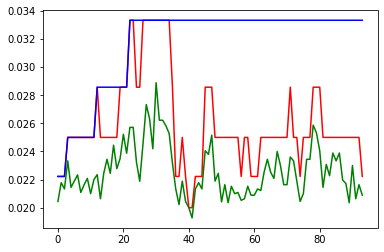

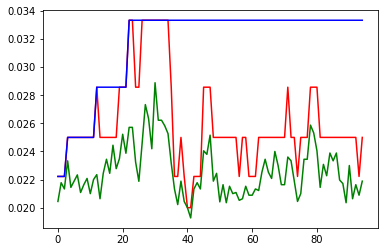

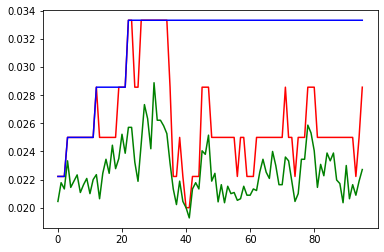

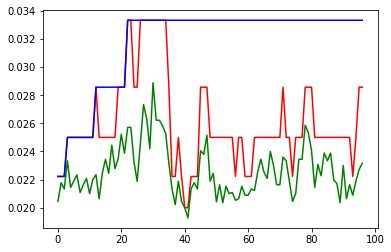

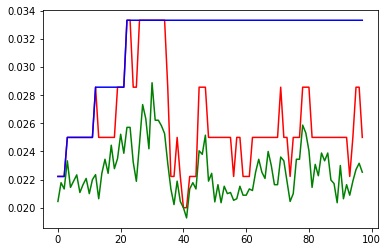

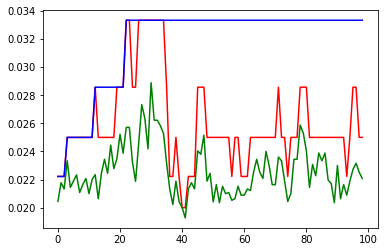

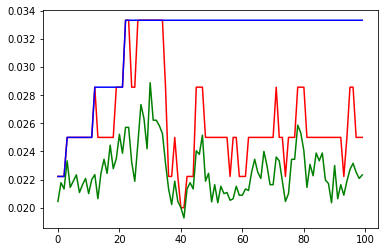

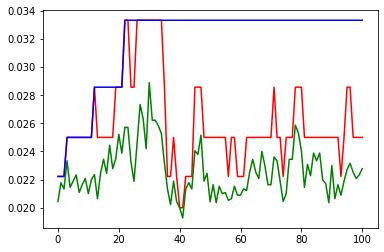

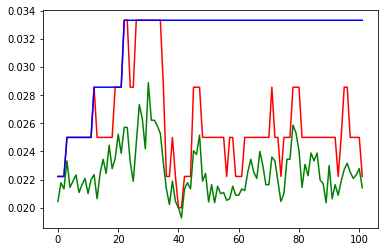

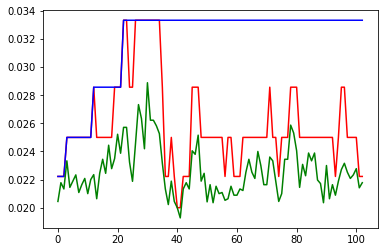

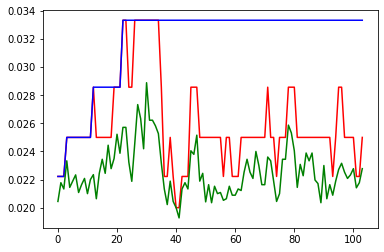

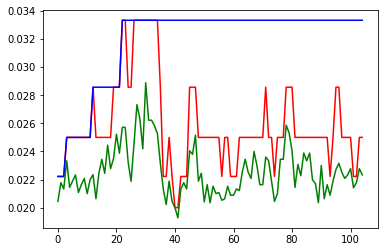

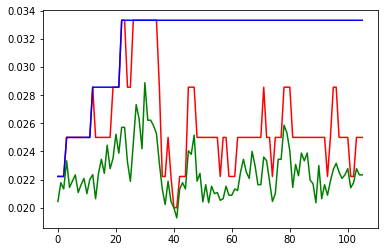

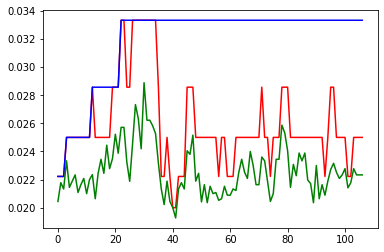

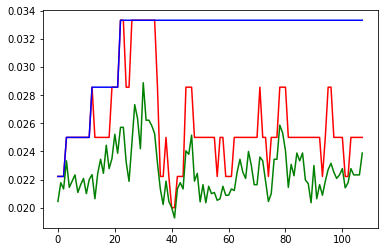

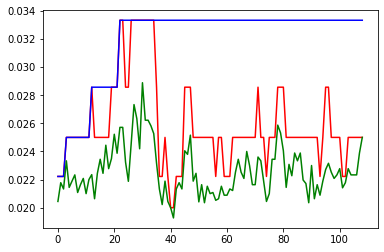

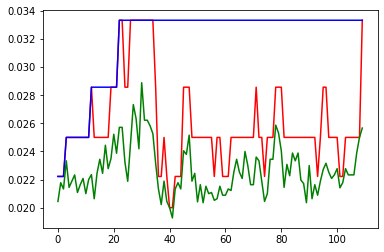

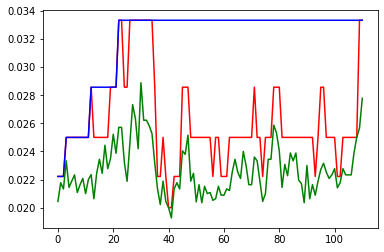

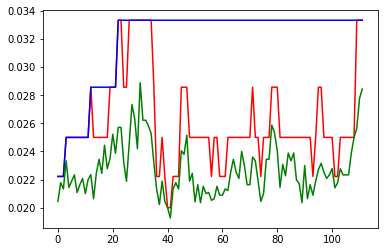

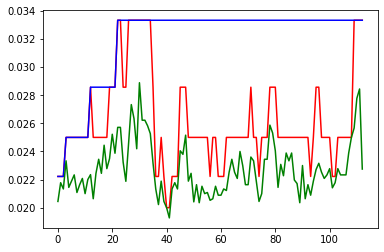

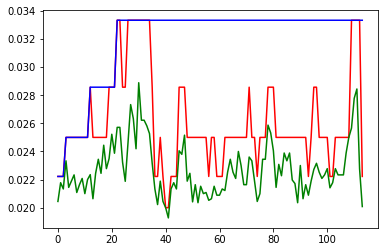

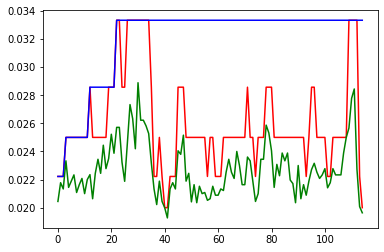

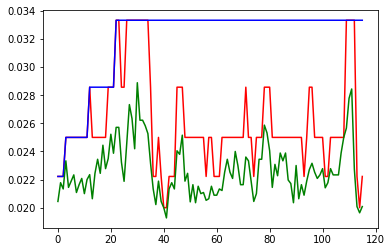

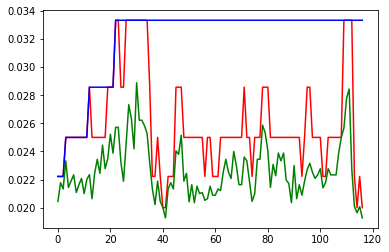

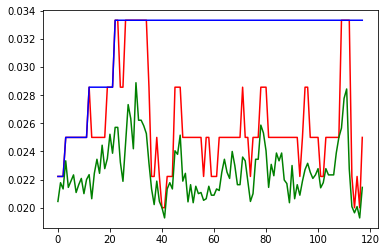

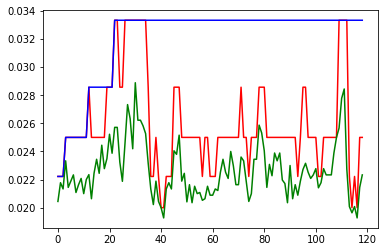

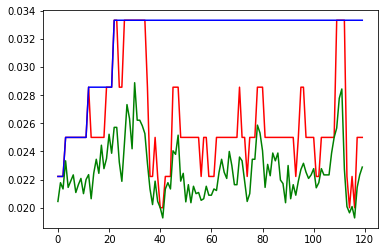

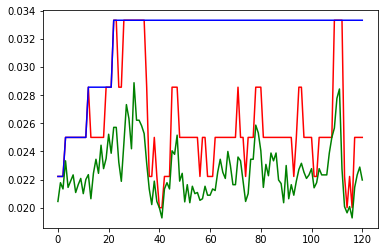

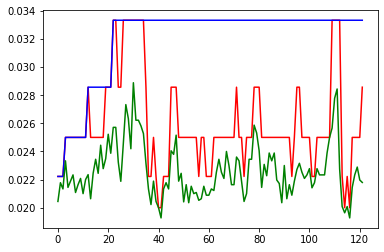

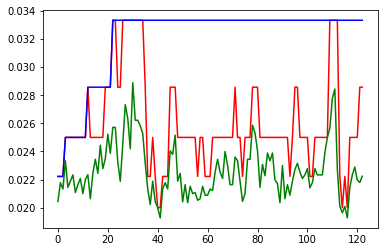

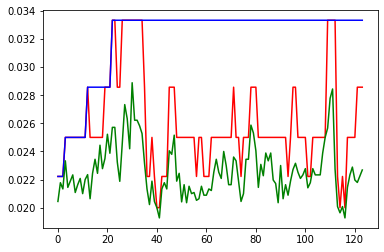

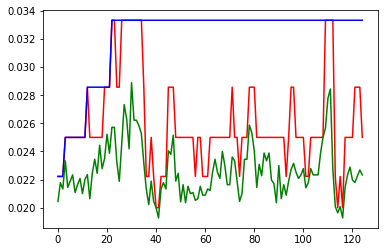

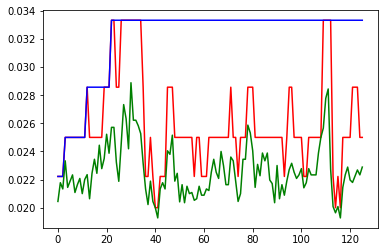

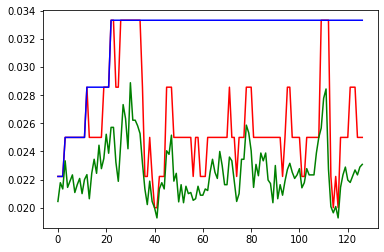

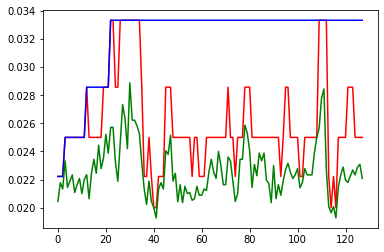

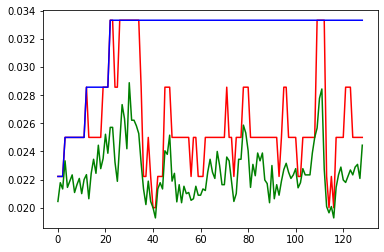

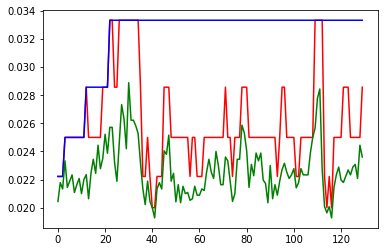

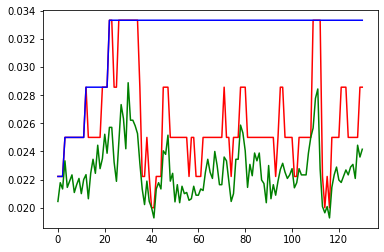

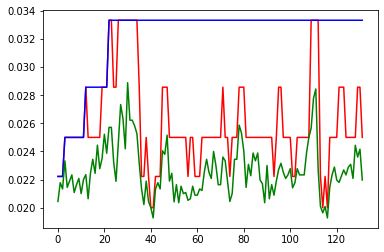

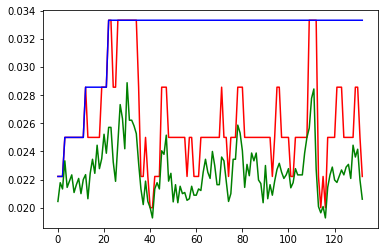

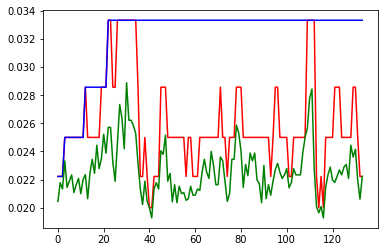

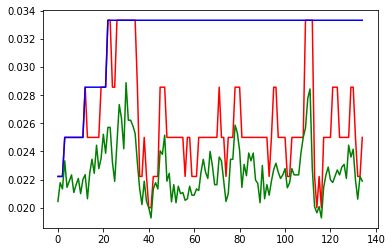

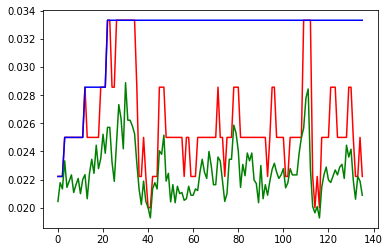

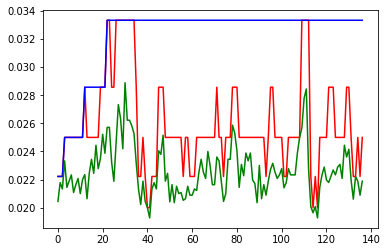

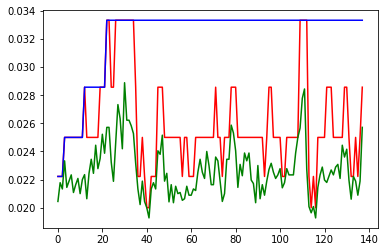

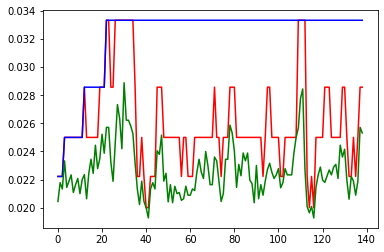

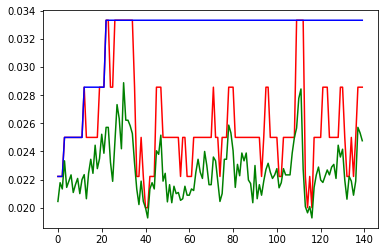

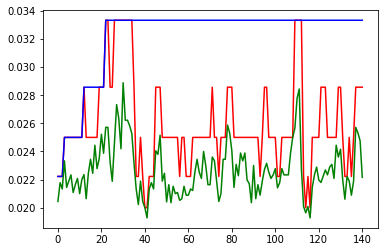

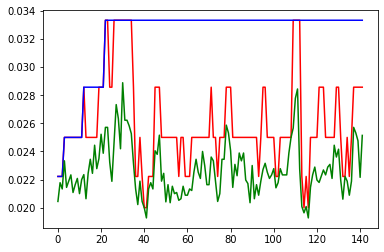

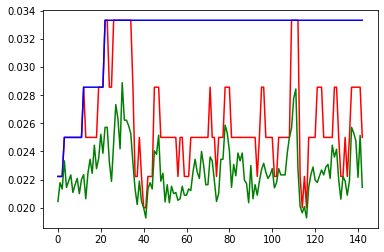

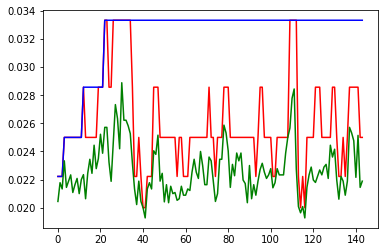

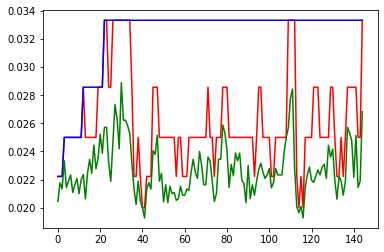

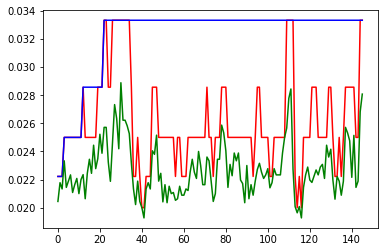

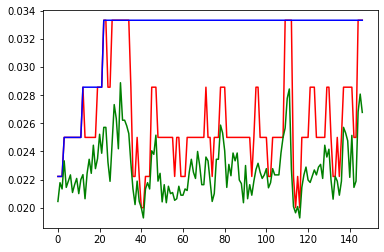

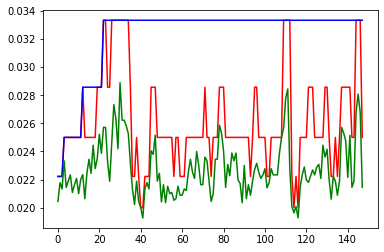

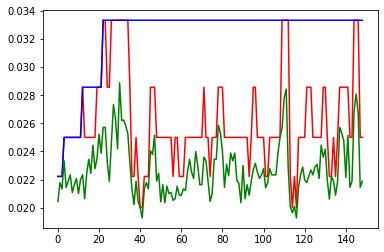

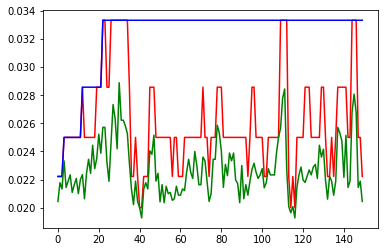

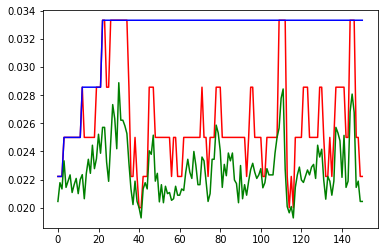

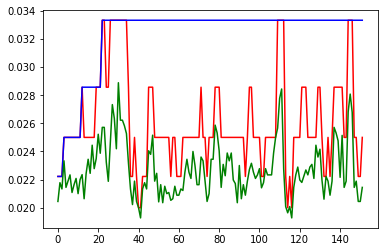

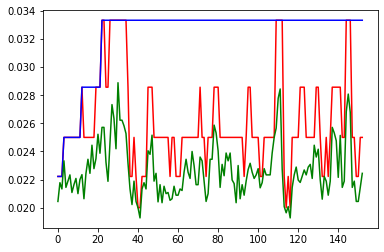

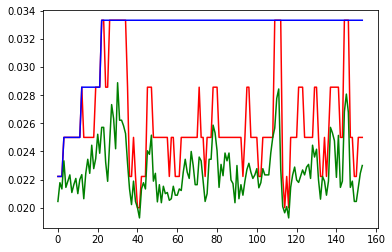

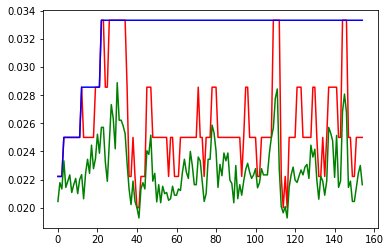

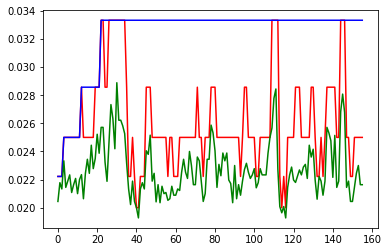

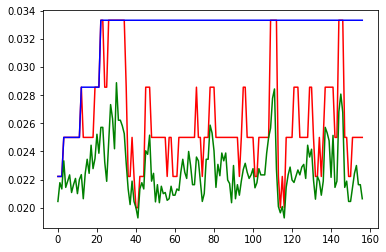

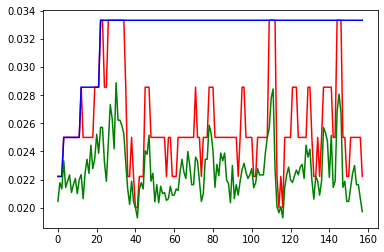

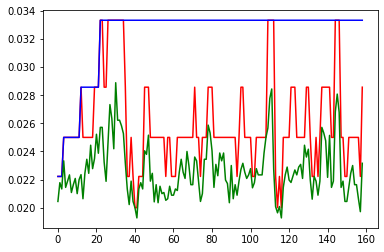

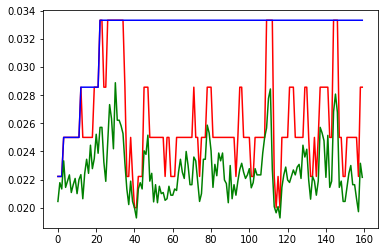

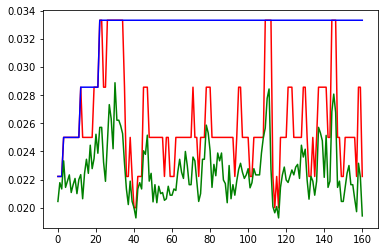

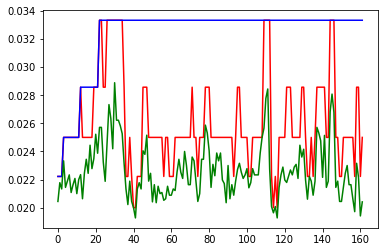

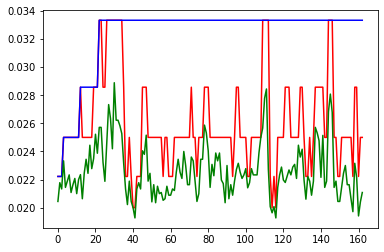

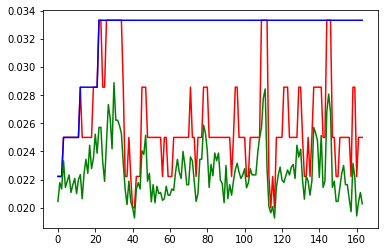

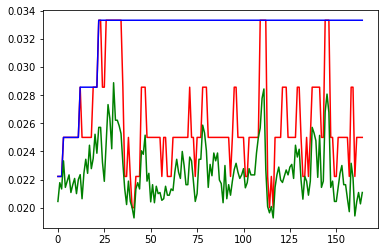

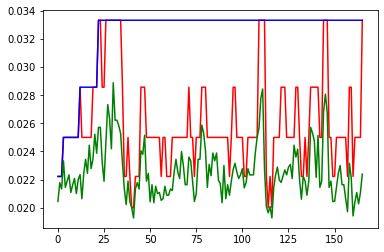

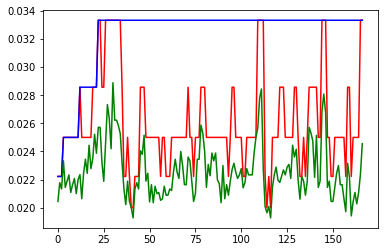

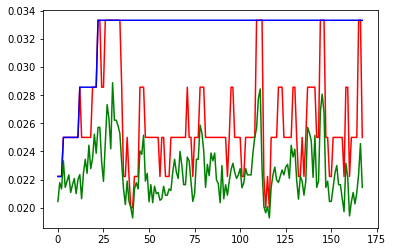

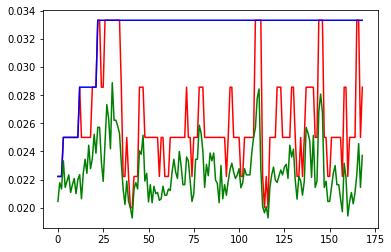

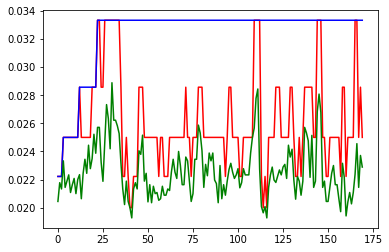

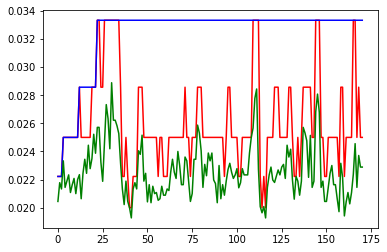

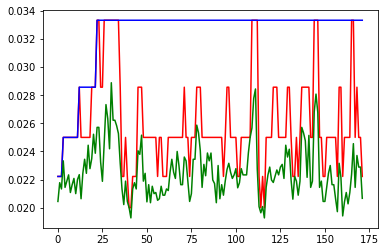

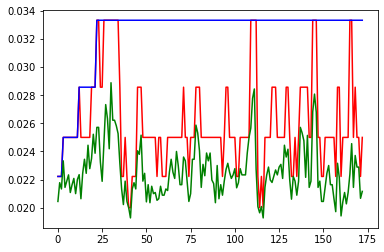

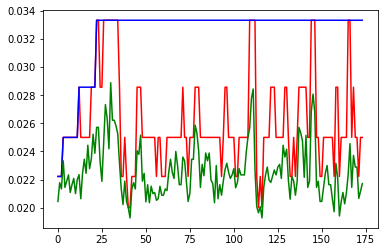

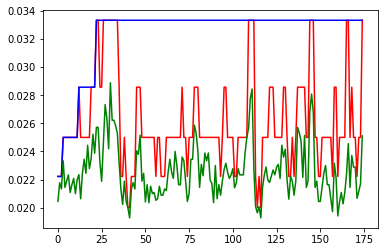

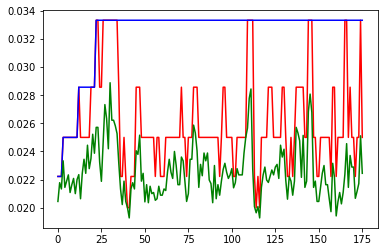

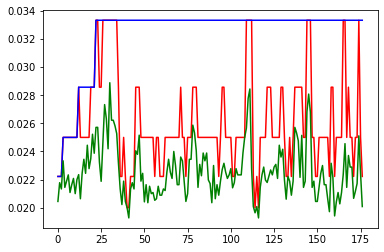

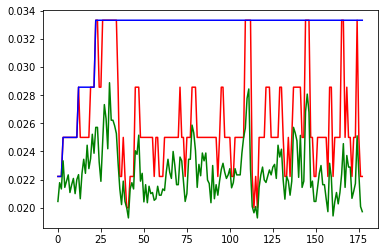

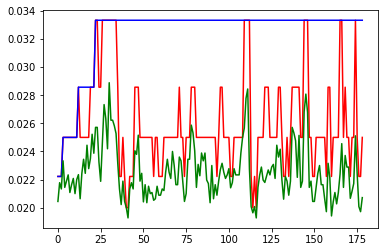

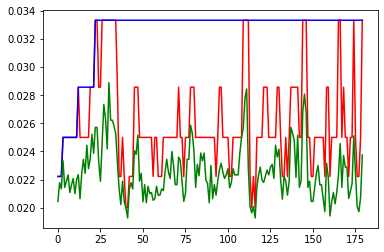

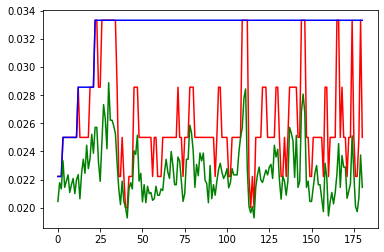

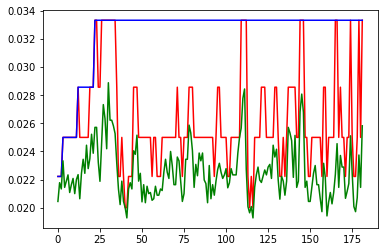

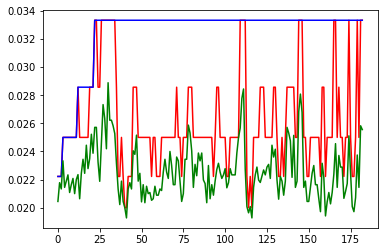

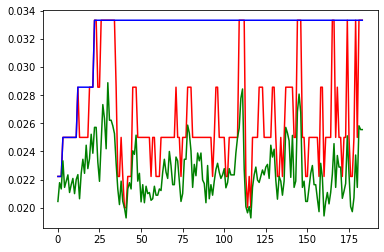

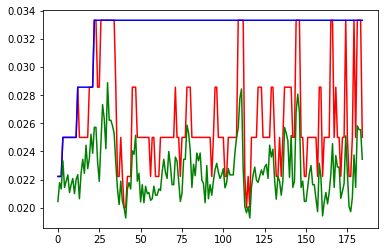

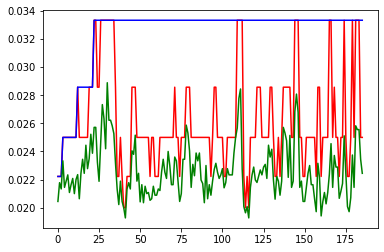

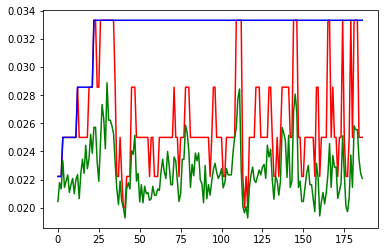

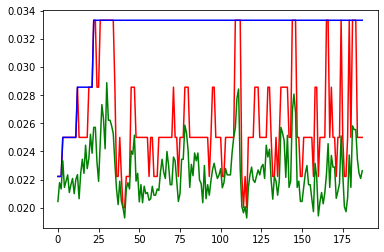

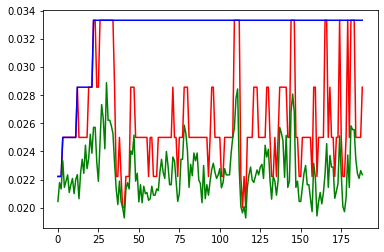

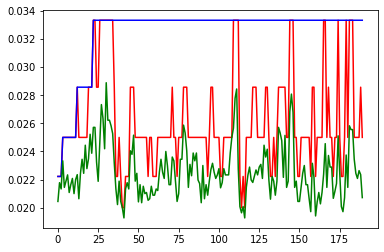

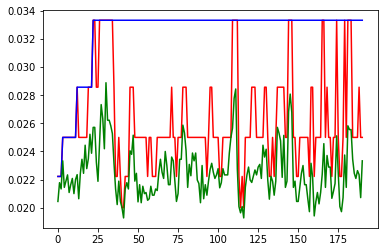

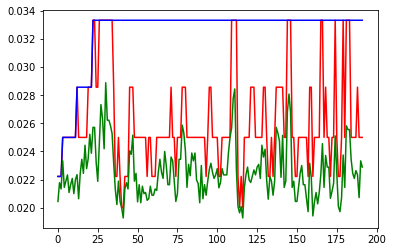

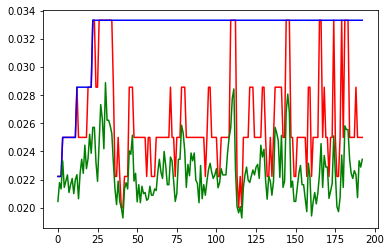

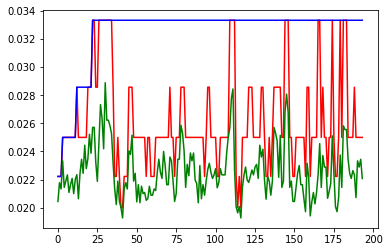

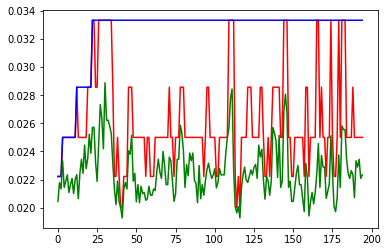

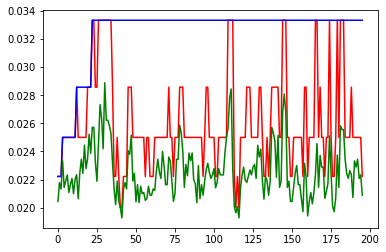

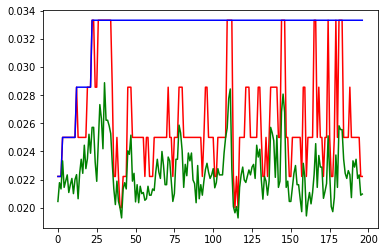

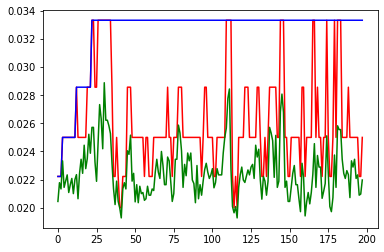

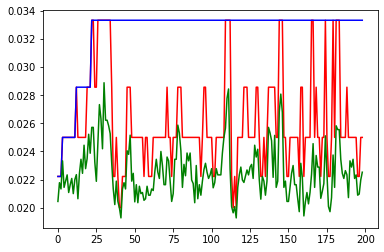

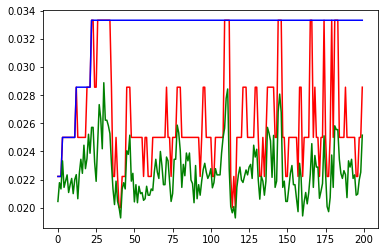

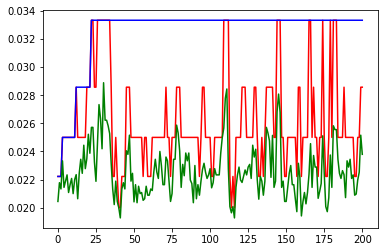

In [ ]:
file_reader       = fileReader("/content/input.txt")
file_readerDict   = file_reader.start()
cityNum           = file_readerDict["cityNum"] 
generationNum     = file_readerDict["generationNum"] 
mutationProb      = file_readerDict["mutationProb"]  
crossoverProb     = file_readerDict["crossoverProb"]
populationSize    = file_readerDict["populationSize"]
distanceMatrix    = file_readerDict["distanceMatrix"]
tsm_environment   = TsmEnvironment(cityNum, distanceMatrix)
output_Manager     = outputManager("/content/output.txt")
genetic_Alghorithm = geneticAlghorithm(tsm_environment, cityNum, generationNum,
                                      mutationProb, crossoverProb, populationSize, output_Manager)
tsm_environment.createEnv()
genetic_Alghorithm.run()